test nb for my projected dark trap class

P. Huft

In [2]:
from numpy import *
import matplotlib.pyplot as plt
from numpy.random import normal

# local imports
from physconsts import *
from rbconsts import mRb

In [3]:
class projected_dark_trap:
    """
    a trap with profile U ~ |1 - E_gaussian|^2
    """
    
    def __init__(self,lmbda,wx,Tdepth,Tatom,m):
        """ A dipole trap object with the beams potential and distribution of 
            atoms specified by Tatom. 
            'wx': x beam waist in focal plane (z=0); wy = wx
            'Tdepth': [K]
            'Tatom': [K]
            'm': atomic mass
        """
        self.wx = wx
        self.wy = wx
        self.Tdepth = Tdepth
        self.T = Tatom
        self.m = m
        
        # FORT and atom parameter stuff
        self.umax = kB*self.Tdepth # the maximum FORT depth
        self.lmbda = lmbda # the trap wavelength [m]

        self.zR = pi*wx**2/self.lmbda
#         self.omega_r = (1/sqrt((self.wx**2+self.wy**2)/2))*sqrt(2*kB*self.Tdepth/m) # radial trap frequency 
        self.omega_z = (1/self.zR)*sqrt(2*kB*self.Tdepth/m) # axial trap frequency
        # print(f"omega_r = {self.omega_r*1e-3:.3f} kHz, omega_z = {self.omega_z*1e-3:.3f} kHz")

    def U(self,x,y,z):
        """ 
        
        """
        zR = self.zR
        w0 = self.wx
        w = w0*sqrt(1+(z/zR)**2) 
        rr = x**2+y**2 # rho squared
        umax = self.umax
        lmbda = self.lmbda
        
        eta = arctan2(z,zR)
        R = z*(1+(zR/z)**2)
        
        uxyz = -umax*(1 - 2*(w0/w)*cos(eta-pi*rr/(R*lmbda))
                     *exp(-rr/w**2)
                     +(w0/w)**2*exp(-2*rr/w**2))
        
        return uxyz
    
    def Uforce(self):
        """
        returns list of force components lambda x,y,z [fx,fy,fz]
        """
        zR = self.zR
        lmbda = self.lmbda
        w0 = self.wx
        w = lambda z: w0*sqrt(1+(z/zR)**2)
        umax = self.umax
                            
        fx = lambda x,y,z: -umax*(4/(w0**2*(z**2+zR**2)**2)
            *exp(-2*(x**2+y**2)*zR**2/(w0**2*(z**2+zR**2)))
            *x*(-zR**4+(1/lmbda)*exp((x**2+y**2)*zR**2/(w0**2*(z**2+zR**2)))
                *sqrt(1+(z/zR)**2)*zR**2*(
                    zR**2*lmbda*cos(pi*(x**2+y**2)*z/(lmbda*(z**2+zR**2))-arctan2(z,zR))
                    +pi*w0**2*z*sin(pi*(x**2+y**2)*z/(lmbda*(z**2+zR**2))-arctan2(z,zR))
                    )
                )
            )
                
        fy = lambda x,y,z: -umax*(4/(w0**2*(z**2+zR**2)**2)
            *exp(-2*(x**2+y**2)*zR**2/(w0**2*(z**2+zR**2)))
            *y*(-zR**4+(1/lmbda)*exp((x**2+y**2)*zR**2/(w0**2*(z**2+zR**2)))
                *sqrt(1+(z/zR)**2)*zR**2*(
                    zR**2*lmbda*cos(pi*(x**2+y**2)*z/(lmbda*(z**2+zR**2))-arctan2(z,zR))
                    +pi*w0**2*z*sin(pi*(x**2+y**2)*z/(lmbda*(z**2+zR**2))-arctan2(z,zR))
                    )
                )
            )
        fz = lambda x,y,z: umax*(2/(w0**2*(z**2+zR**2)**3)
            *exp(-2*(x**2+y**2)*zR**2/(w0**2*(z**2+zR**2)))*zR**2*(
            -2*(x**2+y**2)*z*zR**2+w0**2*z*(z**2+zR**2)
            +(1/lmbda)*exp((x**2+y**2)*zR**2/(w0**2*(z**2+zR**2)))
            *sqrt(1+(z/zR)**2)*(-z*(-2*(x**2+y**2)*zR**2+w0**2
                                         *(z**2+zR**2))*lmbda
                                      *cos(pi*(x**2+y**2)*z/(lmbda*(z**2+zR**2))-arctan2(z,zR))
                                      +w0**2*(pi*(x**2+y**2)*(z-zR)*(z+zR)
                                      +zR*(z**2+zR**2)*lmbda)
                    *sin(pi*(x**2+y**2)*z/(lmbda*(z**2+zR**2))-arctan2(z,zR))
                )
            ) 
        )
    
        
        return fx,fy,fz
        
    
    def xdist(self,events=None,plane=None):
        """ 
        position and velocity component distributions 
        
        the trap is harmonic along z, rho=0 but quartic along rho,z=0.
        the quartic radial distribution is derived in Isenhower et al
        "Atom trapping in an interferometrically generated bottle beam trap"
        """
        
        omega_z = self.omega_z
        T = self.T # atom temp
        Tdepth = self.Tdepth
        m = self.m
        
        dx = dy = (2/sqrt(3))*w0*(T/Tdepth)**(1/4)
        dz = sqrt(kB*T/(m*omega_z**2))
        zlist = normal(0,dz,size=events)
        xlist = normal(0,dx,size=events)
        ylist = normal(0,dy,size=events)
        
        if plane == 'xz':
            return xlist,zlist
        else:
            if events is None:
                return xlist[0],ylist[0],zlist[0]
            return xlist,ylist,zlist
    
    def vdist(self,events):
        """ maxwell boltzmann speeds """
        umax = self.umax
        atoms = ensemble(self.T)
        
        vlist = atoms.sampling_maxboltzv(events,[0,2],self.m) # speeds

        vxlist = empty(events)
        vylist = empty(events)
        vzlist = empty(events)
        
        for i in range(events):
            ex = 2*rand()-1
            ey = 2*rand()-1
            ez = 2*rand()-1
            v = vlist[i]
            A = sqrt(ex**2+ey**2+ez**2)
            vxlist[i] = ex*v/A
            vylist[i] = ey*v/A
            vzlist[i] = ez*v/A

        return vxlist,vylist,vzlist
    
    def distplot(self,events, atoms=True, sx=1.5, sz=1.5, color="bone"):
        """ show atoms in FORT in z = 0 plane before drop and recapture """
        mu = 1e-6
        wx = self.wx
        zR = self.zR
        print(f"zr={zR/mu:.2f} [um], wx={wx/mu:.2f} [um]")
        
        xlist,ylist = self.xdist(events,plane='xz') # positions in [m]
        
        xpts = linspace(-sx*wx,sx*wx,100)
        zpts = linspace(-sz*zR,sz*zR,100)
        xx,zz = meshgrid(xpts,zpts)
        fpts = -self.U(xx,0,zz) # the fort intensity eval'd on the meshgrid
        
        cmap = plt.cm.get_cmap(color)
        
        plt.contourf(xpts/mu,zpts/mu,fpts, cmap=cmap)
        if atoms is True: # otherwise, just a dipole trap plot  
            plt.scatter(xlist/mu,ylist/mu,color='red')
        plt.xlabel("x")
        plt.ylabel("z")
#         plt.axes().set_aspect('equal')
        plt.show()

zr=3888109.72 [um], wx=1000000.00 [um]


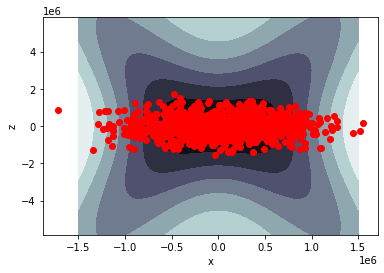

In [10]:
w0 = 1e-6 # 1/e electric field Gaussian waist [um]
T_trap = 5e-4 # energy depth [K]
T_atom = 2e-5
lmbda_trap = .808e-6 # [um]
m = mRb

# my dipole trap object for getting atom dists
trap = projected_dark_trap(lmbda_trap,w0,T_trap,T_atom,m)
trap.distplot(1000)

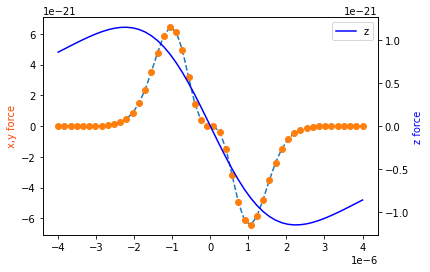

In [9]:
# forces in x,y,z - "normalized units"
fx,fy,fz = trap.Uforce()

xpts = ypts = zpts = linspace(-4*w0,4*w0,50)
# zpts = linspace(-100*trap.zR,100*trap.zR,50)

fig,ax = plt.subplots()
ax.plot(xpts,fx(xpts,0,0),'--',label='x')
ax.plot(ypts,fy(0,ypts,0),'o',label='y')
ax.set_ylabel("x,y force",c='orangered')
ax2 = ax.twinx()
ax2.plot(zpts,fz(0,0,zpts),label='z',c='blue')
# ax.plot(zpts,fz(0,0,zpts),label='z',c='blue')

ax2.set_ylabel("z force",c='blue')
plt.legend()

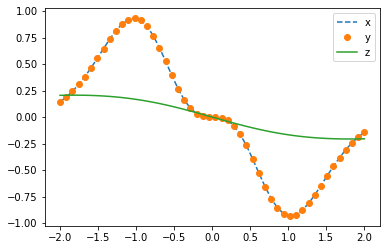

In [6]:
# forces in x,y,z - "normalized units"

lmbda_trap = w0 = 1
T_trap = 1/kB
trap = projected_dark_trap(lmbda_trap,w0,T_trap,T_atom,m)

fx,fy,fz = trap.Uforce()

xpts = ypts = zpts = linspace(-2*w0,2*w0,50)
plt.plot(xpts,fx(xpts,0,0),'--',label='x')
plt.plot(ypts,fy(0,ypts,0),'o',label='y')
plt.plot(zpts,fz(0,0,zpts),label='z')
plt.legend()